In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_10526/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Load Data

In [2]:
# Import some packages we might need
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from scipy import stats
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [3]:
# Can uncomment to install R packages as needed
#utils = importr('utils')
#utils.install_packages('nflreadr')

In [4]:
# Import R packages
nflreadr = importr('nflreadr')

In [5]:
# Scrape play-by-play data and convert to pandas df
seasons=[2022,2023]

plays_r = nflreadr.load_pbp(ro.IntVector(seasons))

with (ro.default_converter + pandas2ri.converter).context():
  plays = ro.conversion.get_conversion().rpy2py(plays_r)

Note: nflreadr caches (i.e., stores a saved version) data by default.
If you expect different output try one of the following:
ℹ Restart your R Session or
ℹ Run `nflreadr::.clear_cache()`.
To disable this warning, run `options(nflreadr.verbose = FALSE)` or add it to your .Rprofile
This message is displayed once every 8 hours.


In [6]:
# Assign down labels to kickoffs (0th down) and extra points or 2pts (5th down)
plays.loc[ plays['down'].isna() & (plays['play_type'].isin(['kickoff'])), 'down' ] = 0.  # kickoffs are labeled as 0th down
plays.loc[ plays['down'].isna() & (plays['play_type'].isin(['extra_point','run','pass'])), 'down' ] = 5.  # extra points and 2pt attempts are labeled as 5th down

# Drop any unlabeled downs
plays = plays.loc[ ~plays['down'].isna() ] # TODO: this drops a few plays, mostly penalties on extra points, not worth the hassle for now

# Index by gameid and playid
plays = plays.set_index(['game_id','play_id']).sort_index(level=[0,1],ascending=[True,True])

# Drop any unused columns
plays = plays[['home_team','away_team','qtr','half_seconds_remaining','down','ydstogo','play_type','posteam','yardline_100','sp','posteam_score','posteam_score_post','defteam_score','defteam_score_post','score_differential','score_differential_post','ep','epa']]

In [7]:
# Can uncomment to print all available columns
#for c in plays.columns:
#    print(c)

In [8]:
# Display head of df
plays.head(60)

home_team away_team  qtr  half_seconds_remaining  \
game_id         play_id                                                    
2022_01_BAL_NYJ 43.0          NYJ       BAL  1.0                  1800.0   
                68.0          NYJ       BAL  1.0                  1796.0   
                89.0          NYJ       BAL  1.0                  1769.0   
                115.0         NYJ       BAL  1.0                  1765.0   
                136.0         NYJ       BAL  1.0                  1741.0   
                172.0         NYJ       BAL  1.0                  1733.0   
                202.0         NYJ       BAL  1.0                  1722.0   
                230.0         NYJ       BAL  1.0                  1701.0   
                254.0         NYJ       BAL  1.0                  1661.0   
                275.0         NYJ       BAL  1.0                  1621.0   
                301.0         NYJ       BAL  1.0                  1579.0   
                330.0         NYJ       BAL  1.0                  1540.0   
                368.0         NYJ       BAL  1.0                  1496.0   
                391.0         NYJ       BAL  1.0                  1489.0   
                412.0         NYJ       BAL  1.0                  1451.0   
                436.0         NYJ       BAL  1.0                  1411.0   
                469.0         NYJ       BAL  1.0                  1407.0   
                490.0         NYJ       BAL  1.0                  1371.0   
                511.0         NYJ       BAL  1.0                  1336.0   
                533.0         NYJ       BAL  1.0                  1332.0   
                552.0         NYJ       BAL  1.0                  1325.0   
                574.0         NYJ       BAL  1.0                  1322.0   
                595.0         NYJ       BAL  1.0                  1273.0   
                617.0         NYJ       BAL  1.0                  1268.0   
                636.0         NYJ       BAL  1.0                  1261.0   
                660.0         NYJ       BAL  1.0                  1221.0   
                697.0         NYJ       BAL  1.0                  1207.0   
                723.0         NYJ       BAL  1.0                  1196.0   
                744.0         NYJ       BAL  1.0                  1148.0   
                768.0         NYJ       BAL  1.0                  1104.0   
                790.0         NYJ       BAL  1.0                  1099.0   
                809.0         NYJ       BAL  1.0                  1096.0   
                824.0         NYJ       BAL  1.0                  1096.0   
                846.0         NYJ       BAL  1.0                  1091.0   
                868.0         NYJ       BAL  1.0                  1087.0   
                892.0         NYJ       BAL  1.0                  1020.0   
                911.0         NYJ       BAL  1.0                  1013.0   
                935.0         NYJ       BAL  1.0                   972.0   
                959.0         NYJ       BAL  1.0                   925.0   
                999.0         NYJ       BAL  2.0                   900.0   
                1021.0        NYJ       BAL  2.0                   896.0   
                1051.0        NYJ       BAL  2.0                   885.0   
                1075.0        NYJ       BAL  2.0                   858.0   
                1099.0        NYJ       BAL  2.0                   817.0   
                1120.0        NYJ       BAL  2.0                   781.0   
                1144.0        NYJ       BAL  2.0                   740.0   
                1165.0        NYJ       BAL  2.0                   700.0   
                1194.0        NYJ       BAL  2.0                   660.0   
                1216.0        NYJ       BAL  2.0                   655.0   
                1236.0        NYJ       BAL  2.0                   651.0   
                1260.0        NYJ       BAL  2.0                   617.0

# Calculate Expected Points

In [9]:
###
def NextPointsScored(df):
    """
    """
    # Initialize data
    num_plays = len(df)
    
    time_remaining = df['half_seconds_remaining'].values
    posteam = df['posteam'].values
    delta = df['score_differential_post'].values - df['score_differential'].values
    scoring_play = df['sp'].values.astype('bool')
    fifth_down = df['down'].values > 4.5 
    
    zeros = 0.*df['down']
    result = np.zeros(num_plays)
    
    # Loop over current plays
    i = 0
    while i < num_plays:
        t_now = time_remaining[i]
        # Loop over future plays
        for j in range(i,num_plays):
            # Check if time has run out
            if time_remaining[j] > t_now:
                # No score before time expires
                break
                
            # Check if it's a scoring play or 5th down play (extra point or 2pt)
            elif scoring_play[j] or fifth_down[j]:
                # Record any necessary score
                result[i:j+1][posteam[i:j+1] == posteam[j]] = delta[j]
                result[i:j+1][posteam[i:j+1] != posteam[j]] = -delta[j]  # TODO: deal with NANs for teams
                break
        
        # Advance current play forward
        i = j + 1
                
    # Return result
    return zeros + result

In [10]:
# Calculate next points scored
plays['next_points'] = plays.groupby('game_id').apply(NextPointsScored).values

In [11]:
# Display the features we will use in our fitting
plays[['half_seconds_remaining','qtr','down','ydstogo','yardline_100','posteam','next_points','score_differential','score_differential_post']].head(60)

half_seconds_remaining  qtr  down  ydstogo  \
game_id         play_id                                               
2022_01_BAL_NYJ 43.0                     1800.0  1.0   0.0      0.0   
                68.0                     1796.0  1.0   1.0     10.0   
                89.0                     1769.0  1.0   1.0     10.0   
                115.0                    1765.0  1.0   2.0     10.0   
                136.0                    1741.0  1.0   3.0      5.0   
                172.0                    1733.0  1.0   4.0     15.0   
                202.0                    1722.0  1.0   1.0     10.0   
                230.0                    1701.0  1.0   2.0      6.0   
                254.0                    1661.0  1.0   3.0      2.0   
                275.0                    1621.0  1.0   1.0     10.0   
                301.0                    1579.0  1.0   2.0     10.0   
                330.0                    1540.0  1.0   3.0      2.0   
                368.0                    1496.0  1.0   4.0      1.0   
                391.0                    1489.0  1.0   1.0     10.0   
                412.0                    1451.0  1.0   2.0     12.0   
                436.0                    1411.0  1.0   3.0      9.0   
                469.0                    1407.0  1.0   1.0     10.0   
                490.0                    1371.0  1.0   2.0      9.0   
                511.0                    1336.0  1.0   3.0      9.0   
                533.0                    1332.0  1.0   4.0      9.0   
                552.0                    1325.0  1.0   1.0     10.0   
                574.0                    1322.0  1.0   2.0     10.0   
                595.0                    1273.0  1.0   3.0      9.0   
                617.0                    1268.0  1.0   4.0      9.0   
                636.0                    1261.0  1.0   1.0     10.0   
                660.0                    1221.0  1.0   1.0     10.0   
                697.0                    1207.0  1.0   1.0     19.0   
                723.0                    1196.0  1.0   1.0     10.0   
                744.0                    1148.0  1.0   2.0     11.0   
                768.0                    1104.0  1.0   3.0      3.0   
                790.0                    1099.0  1.0   4.0      3.0   
                809.0                    1096.0  1.0   0.0      0.0   
                824.0                    1096.0  1.0   1.0     10.0   
                846.0                    1091.0  1.0   2.0     10.0   
                868.0                    1087.0  1.0   3.0     10.0   
                892.0                    1020.0  1.0   4.0      1.0   
                911.0                    1013.0  1.0   1.0     10.0   
                935.0                     972.0  1.0   1.0     10.0   
                959.0                     925.0  1.0   2.0      8.0   
                999.0                     900.0  2.0   3.0      5.0   
                1021.0                    896.0  2.0   4.0      5.0   
                1051.0                    885.0  2.0   1.0     10.0   
                1075.0                    858.0  2.0   1.0     10.0   
                1099.0                    817.0  2.0   1.0     10.0   
                1120.0                    781.0  2.0   2.0      6.0   
                1144.0                    740.0  2.0   1.0     10.0   
                1165.0                    700.0  2.0   2.0     10.0   
                1194.0                    660.0  2.0   3.0      4.0   
                1216.0                    655.0  2.0   4.0      4.0   
                1236.0                    651.0  2.0   1.0     10.0   
                1260.0                    617.0  2.0   2.0      5.0   
                1284.0                    583.0  2.0   1.0     10.0   
                1310.0                    539.0  2.0   2.0     10.0   
                1337.0                    496.0  2.0   3.0     12.0   
                1359.0                    488.0  

In [12]:
# Select the features we will use in our expected points model, make sure they don't have any lookahead!
fit_cols = ['down','ydstogo','yardline_100']
#fit_cols = ['down','ydstogo','yardline_100','half_seconds_remaining','score_differential']

# Loop over random forest hyperparameters
n_splits = 10
n_estimators = 100
for max_depth in range(5,12):
    for min_samples_leaf in range(1,2):

        # Get feature and target variables
        X = plays[fit_cols].values
        Y = plays['next_points'].values

        # Set up a k-folds cross-validation
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)

        cum_Y_test = np.ones_like(Y) * np.nan
        cum_Y_pred = np.ones_like(Y) * np.nan

        for train_index_raw,test_index in kf.split(X):

            # Add a buffer around training data to prevent any accidental lookahead/leakage
            buffer_low = np.arange(test_index[0] - 100, test_index[0])
            buffer_high = np.arange(test_index[-1]+1, test_index[-1] + 101)
            train_index = np.array([ x for x in train_index_raw if ( (x not in buffer_low) & (x not in buffer_high) ) ])
            
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Train random forest model with current hyperparameters
            rf_exp = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            rf_exp.fit(X_train, Y_train)

            cum_Y_test[test_index] = Y_test
            cum_Y_pred[test_index] = rf_exp.predict(X_test)

        # Train random forest model on all data
        rf_exp = ExtraTreesRegressor(n_estimators=300, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        rf_exp.fit(X, Y)

        print()
        print('#####')
        print()
        print(max_depth, min_samples_leaf)
        print()
        print('feature importances:')
        print()
        for a,b in zip(fit_cols,rf_exp.feature_importances_):
            print(a,b)
        print()
        print('Performance metrics:')
        print()
        print('var, IS:', explained_variance_score(Y,rf_exp.predict(X)))
        print('var, OOS:', explained_variance_score(cum_Y_test,cum_Y_pred))
        print()
        print('rho, IS:', stats.pearsonr(Y,rf_exp.predict(X))[0])
        print('rho, OOS:', stats.pearsonr(cum_Y_test,cum_Y_pred)[0])
        print()
        print('mde, IS:', median_absolute_error(Y,rf_exp.predict(X)))
        print('mde, OOS:', median_absolute_error(cum_Y_test,cum_Y_pred))
        print()
        print('mae, IS:', mean_absolute_error(Y,rf_exp.predict(X)))
        print('mae, OOS:', mean_absolute_error(cum_Y_test,cum_Y_pred))
        print()
        print('mse, IS:', mean_squared_error(Y,rf_exp.predict(X)))
        print('mse, OOS:', mean_squared_error(cum_Y_test,cum_Y_pred))


#####

5 1

feature importances:

down 0.2325986007340247
ydstogo 0.0332203369923939
yardline_100 0.7341810622735814

Performance metrics:

var, IS: 0.12344404928336739
var, OOS: 0.12261679201099096

rho, IS: 0.3541098223670982
rho, OOS: 0.3523607168116374

mde, IS: 2.788565112053861
mde, OOS: 2.791234696645775

mae, IS: 3.184645339627208
mae, OOS: 3.1855262899864463

mse, IS: 15.173261188759009
mse, OOS: 15.187581198005818

#####

6 1

feature importances:

down 0.25271327577159736
ydstogo 0.030735983455778736
yardline_100 0.7165507407726239

Performance metrics:

var, IS: 0.12675612771085432
var, OOS: 0.12510184950551317

rho, IS: 0.3570794831221719
rho, OOS: 0.35449349661764973

mde, IS: 2.727825565357051
mde, OOS: 2.7556348903204775

mae, IS: 3.1660781770859705
mae, OOS: 3.1659818920461142

mse, IS: 15.115928817657283
mse, OOS: 15.144564737785126

#####

7 1

feature importances:

down 0.26085283158623523
ydstogo 0.035077809767513964
yardline_100 0.7040693586462509

Performance me

/tmp/ipykernel_10526/181976254.py:16: RuntimeWarning: invalid value encountered in scalar divide
  avg_new += [ ( (plays['ep_new'] >= bins[i]) * (plays['ep_new'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep_new'] >= bins[i]) & (plays['ep_new'] <= bins[i+1]) ).sum() ]
/tmp/ipykernel_10526/181976254.py:17: RuntimeWarning: invalid value encountered in scalar divide
  avg_old += [ ( (plays['ep'] >= bins[i]) * (plays['ep'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep'] >= bins[i]) & (plays['ep'] <= bins[i+1]) ).sum() ]


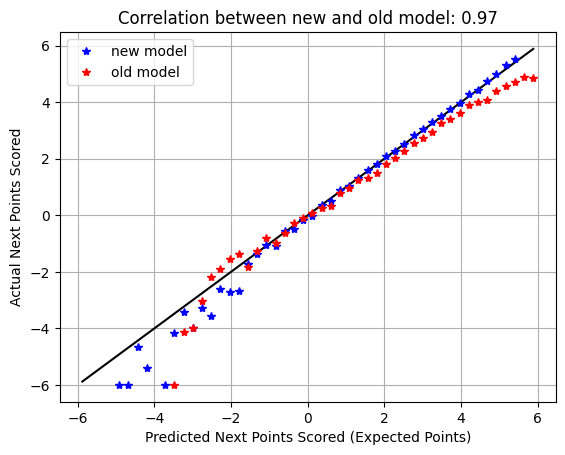

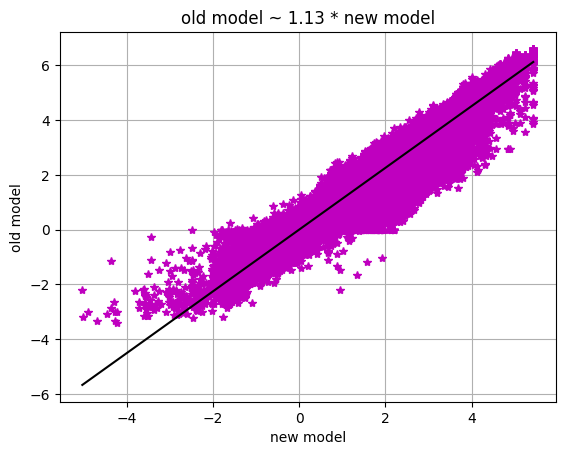

In [13]:
# Train final random forest with model that performed best out-of-sample (OOS)
# NOTE: this will produce in-sample (IS) predictions, meaning performance will be higher than OOS (see CV results above)
# TODO: automatically store the OOS predictions from the best-performing model, will give truer results and fairer comparison
rf_exp = ExtraTreesRegressor(n_estimators=300, max_depth=8, min_samples_leaf=1)
rf_exp.fit(X, Y)

plays['ep_new'] = rf_exp.predict(X)

# Evaluate the calibration of the EP models
bins = np.linspace(-6, 6, 51)
bin_centers = 0.5*(bins[:-1] + bins[1:])

avg_new = []
avg_old = []
for i,bin_center in enumerate(bin_centers):
    avg_new += [ ( (plays['ep_new'] >= bins[i]) * (plays['ep_new'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep_new'] >= bins[i]) & (plays['ep_new'] <= bins[i+1]) ).sum() ]
    avg_old += [ ( (plays['ep'] >= bins[i]) * (plays['ep'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep'] >= bins[i]) & (plays['ep'] <= bins[i+1]) ).sum() ]

plt.plot(bin_centers, bin_centers, 'k-')
plt.plot(bin_centers, avg_new, 'b*', label='new model')
plt.plot(bin_centers, avg_old, 'r*', label='old model')
plt.xlabel('Predicted Next Points Scored (Expected Points)')
plt.ylabel('Actual Next Points Scored')
plt.title(f"Correlation between new and old model: {stats.pearsonr(plays['ep_new'],plays['ep'])[0]:.2f}")
plt.grid()
plt.legend()

plt.show()

# Compare the old and new EP models predictions against each other
beta = np.nansum(plays['ep'] * plays['ep_new']) / np.nansum(plays['ep_new'] * plays['ep_new'])

plt.plot(plays['ep_new'], plays['ep'], 'm*',)
plt.plot(np.linspace(plays['ep_new'].min(),plays['ep_new'].max(),10), beta * np.linspace(plays['ep_new'].min(),plays['ep_new'].max(),10), 'k-')
plt.xlabel('new model')
plt.ylabel('old model')
plt.title(f"old model ~ {beta:.2f} * new model")
plt.grid()

plt.show()